## Geting the text tuple including certain search key word

In [1]:
def get_research_text_tuple(search_query,language = 'en'):
    consumer_key = 'QZ3xeMG7KYSyUC5SV7Fe5Qp0H'
    consumer_secret = 'Wuf23nMADhcvipBHkJ93haueFC1cNbNH6o2jG8wH7H4ROM1wxB'
    access_token = '994776288232640517-lDoCvNH1vCJBs1hj0nlpXe96SeqLFgV'
    access_token_secret = 'fVkg6aJpaa1Rn6z41pVhhvqCQ8wCLKMclfphgR65emmfJ'
    import tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    ## fill in your search query and store your results in a variable
    results = api.search(q = search_query,result_type = "recent", tweet_mode='extended',
                     count = 100,lang=language)
    tweet_result = list()
    for i in range(len(results)):
        user_id = results[i]._json['user']['id_str']
        review_text = results[i]._json['full_text']
        tweet_result.append((user_id,review_text))
    return tweet_result

## Test this function using key word 'China'

In [2]:
tweet_result = get_research_text_tuple('China OR china OR CHINA -filter:links')

## Using NRC Emotion Lexicon: words coded into emotional categories (Multilingual)
### http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [3]:
def get_nrc_data(multi_language = False):
    emotion_dict=dict()
    if multi_language:
        nrc = nrc = pd.read_csv('NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.csv',
                                encoding = "ISO-8859-1")
        for x in range(len(nrc)):
            for y in range(105):
                word = nrc.iloc[x][y]
                if emotion_dict.get(word):
                    for i in ['Positive','Negative','Anger','Anticipation','Disgust',
                              'Fear','Joy','Sadness','Surprise','Trust']:
                        if nrc.iloc[x][i]==1:
                            emotion_dict[word].add(i)
                else:
                    emotion_dict[word] = set(' '.join(
                        list(np.array(['Positive','Negative','Anger','Anticipation',
                                       'Disgust','Fear','Joy','Sadness','Surprise','Trust'])
                             * np.array(nrc.iloc[x][105:]))).split())
    else:
        nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
        count=0
        with open(nrc,'r') as f:
            all_lines = list()
            for line in f:
                if count < 46:
                    count+=1
                    continue
                line = line.strip().split('\t')
                if int(line[2]) == 1:
                    if emotion_dict.get(line[0]):
                        emotion_dict[line[0]].append(line[1])
                    else:
                        emotion_dict[line[0]] = [line[1]]
    return emotion_dict

In [4]:
emotion_dict = get_nrc_data()

## Define the emotion analyzer

In [5]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y} 
    #list comprehension - 
    #emotion for (emotion_list in emotion_dict.values() for emotion in emotion_list
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0
    
    def tokenize(sentence):
        import string
        from nltk.tokenize import word_tokenize
    # remove all ASCII punctuations and numbers
        del_estr = string.punctuation + string.digits  
        replace = " "*len(del_estr)
        tran_tab = str.maketrans(del_estr, replace)
        sentence = sentence.translate(tran_tab)  
    
    #word tokenized
        words = word_tokenize(sentence)  
    
    # Construct a list of words after getting rid of unimportant ones and numbers
        from nltk.corpus import stopwords
        lowercase_words = [word.lower() for word in words if word not in stopwords.words() and word.isalpha()]
        return lowercase_words
    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in tokenize(text):
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/total_words #relative scoring0
    return emotion_count

## Store the analysis result in dataframe

In [6]:
def comparative_emotion_analyzer(text_tuples,object_name="User"):
    import pandas as pd
    df = pd.DataFrame(columns=[object_name,'Fear','Trust','Negative',
                           'Positive','Joy','Disgust','Anticipation',
                           'Sadness','Surprise'],)
    df.set_index(object_name,inplace=True)
    
    output = df    
    for text_tuple in text_tuples:
        text = text_tuple[1] 
        result = emotion_analyzer(text)
        df.loc[text_tuple[0]] = [result['fear'],result['trust'],
                  result['negative'],result['positive'],result['joy'],result['disgust'],
                  result['anticipation'],result['sadness'],result['surprise']]
    return output
#And test it        
df = comparative_emotion_analyzer(tweet_result)

In [7]:
text=''
for snippet in tweet_result:
    text+=snippet[1]

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [8]:
# Here remove the key words we search  
STOPWORDS.update(['China','Chinese','RT','https',"will","amp"])

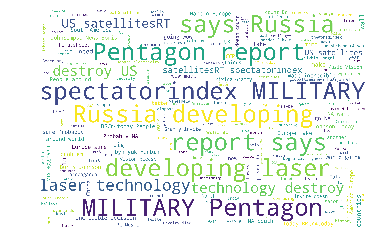

In [9]:
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3600,height=2400,max_words = 200).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Create Negative Score column and Positive column to sort the result

In [10]:
df['Neg_Score'] = df.Fear + df.Negative+ + df.Disgust + df.Sadness

In [11]:
df['Pos_Score'] = df.Trust + df.Positive + df.Joy + df.Anticipation + df.Surprise

In [12]:
df.sort_values(by="Neg_Score" , ascending=False)[:10]

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score
User,,,,,,,,,,,
720265901115711489,0.095238,0.000000,0.142857,0.190476,0.000000,0.000000,0.000000,0.095238,0.000000,0.333333,0.190476
81886236,0.021739,0.000000,0.108696,0.000000,0.021739,0.108696,0.000000,0.043478,0.000000,0.282609,0.021739
215179987,0.028571,0.028571,0.085714,0.028571,0.028571,0.057143,0.028571,0.057143,0.028571,0.228571,0.142857
43161880,0.055556,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.055556,0.000000,0.222222,0.000000
18061382,0.049180,0.016393,0.065574,0.016393,0.000000,0.032787,0.000000,0.065574,0.032787,0.213115,0.065574
103415282,0.055556,0.000000,0.055556,0.055556,0.027778,0.055556,0.027778,0.027778,0.000000,0.194444,0.111111
81955968,0.054054,0.000000,0.054054,0.000000,0.000000,0.027027,0.000000,0.054054,0.000000,0.189189,0.000000
141598993,0.000000,0.000000,0.086957,0.000000,0.000000,0.043478,0.000000,0.043478,0.000000,0.173913,0.000000
78408027,0.055556,0.000000,0.055556,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.166667,0.055556


In [13]:
neg_user = df.sort_values(by="Neg_Score" , ascending=False)[:10]

In [14]:
neg_count = len(df[(df.Neg_Score>0.0) & (df.Pos_Score<=0.0)])
print('The proportion of user hold negative attitudes accroing to analysis is {:.2%}.'.format(neg_count/len(df)))

The proportion of user hold negative attitudes accroing to analysis is 10.00%.


In [15]:
pos_count = len(df[(df.Neg_Score<=0.0) & (df.Pos_Score>0.0)])
print('The proportion of user hold positive attitudes accroing to analysis is {:.2%}.'.format(pos_count/len(df)))

The proportion of user hold positive attitudes accroing to analysis is 13.00%.


In [16]:
netural_count = len(df[(df.Neg_Score>0.0) & (df.Pos_Score>0.0)])
print('The proportion of user hold netural attitudes accroing to analysis is {:.2%}.'.format(netural_count/len(df)))

The proportion of user hold netural attitudes accroing to analysis is 64.00%.


In [17]:
def get_user_history_text(dataframe):
    consumer_key = 'QZ3xeMG7KYSyUC5SV7Fe5Qp0H'
    consumer_secret = 'Wuf23nMADhcvipBHkJ93haueFC1cNbNH6o2jG8wH7H4ROM1wxB'
    access_token = '994776288232640517-lDoCvNH1vCJBs1hj0nlpXe96SeqLFgV'
    access_token_secret = 'fVkg6aJpaa1Rn6z41pVhhvqCQ8wCLKMclfphgR65emmfJ'
    import tweepy
    import re
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    user_tweets = dict()
    for i in dataframe.index:
        user_tweets[i] = api.user_timeline(i, count=200,tweet_mode='extended',lang='en')
    user_text = {}
    for i in user_tweets.keys():
        for j in range(len(user_tweets[i])):  
            if i in user_text.keys():  
                user_text[i].append(re.sub(r"(https\S+)", "",user_tweets[i][j]._json['full_text']))
            else:  
                user_text[i] = [re.sub(r"(https\S+)", "",user_tweets[i][j]._json['full_text'])]
    user_tuple = [(k, str(v)) for k, v in user_text.items()]
    return user_tuple

In [18]:
user_tuple = get_user_history_text(neg_user)

## Have a intuitive understanding about these users' key words using WordCloud

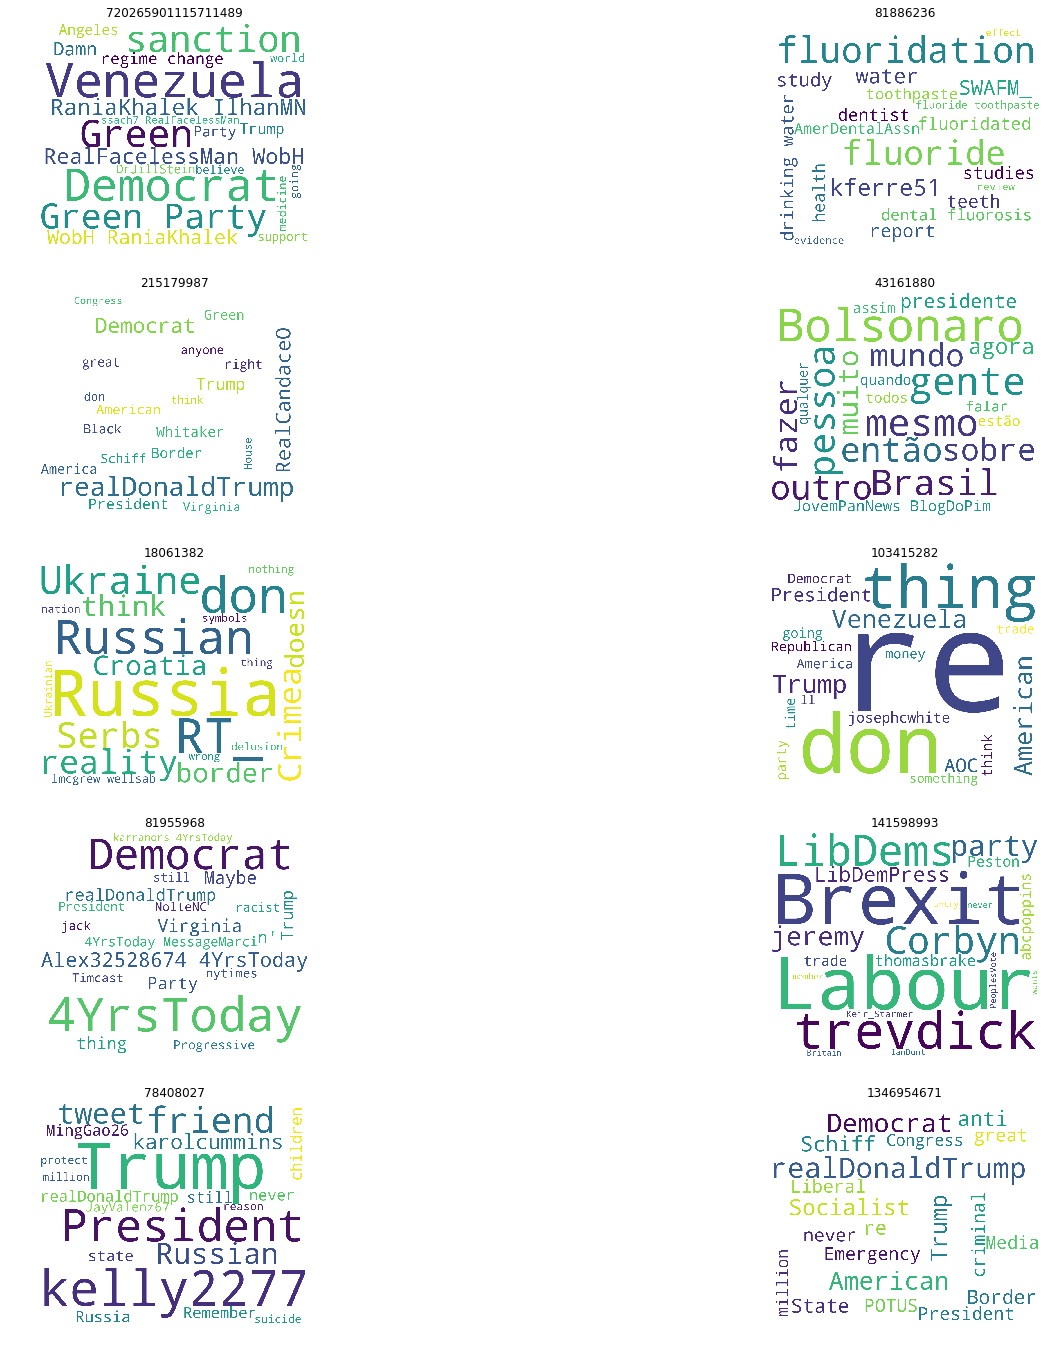

In [19]:
texts = user_tuple
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['people','year','gt','C O','Please','co']
STOPWORDS.remove('China')
STOPWORDS.remove('Chinese')

def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 5
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string


#Set up side by side clouds
COL_NUM = 2
ROW_NUM = 5
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(24,24))

for i in range(0,len(texts)):
    text_string = remove_words(texts[i][1])
    text_string = remove_short_words(text_string)
    ax = axes[i//2, i%2] 
    ax.set_title(texts[i][0])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1000,max_words=20).generate(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')
plt.show()

## Some Indepth Analysis about the user's attitude

### Generally, around 10% users show negative attitudes towards "China" and 13% users show negative attitudes, while 64% show netural attitudes.
### From the worldCloud result and analysis of their historical twitter results, I have some interesting discoveries about negative concerns:

<ol>
<li>Debate about 'Green New Deal",they think this deal may destory US fuel industry and help China to grow over US, the same as Russia and India</li>
<ul>
<li>https://twitter.com/alexanderbruz/status/1093866653136363520
<li>https://powerthefuture.com/the-day-the-green-new-deal-officially-went-off-the-rails/
</ul>
<li>Argument about 'Trade War'</li>
<ul>
<li>https://twitter.com/nfergus/status/1092075927792566272</li>
</ul>
<li>Supporters of Donald Trump and Republican</li>
<ul>
<li>https://twitter.com/nfergus/status/1092075927792566272</li>
</ul>
</ol>

### The positive parts are bisically regarding Chinese Spring Festival and China economy</h2>

## Potential Improvement for this analysis

<ol>
    
<li>Application of sentimital analysis of user's historical twitters, to verify whether the users' normal attitude towards things</li>

<li>Tokenize method: Word_tokenize or Sentence_tokenize ? A measurement need to be done</li>

<li>Multilingual NLP package like ployglot can be considered to use</li>

</ol>

## Sentimental analysis on a specific user

In [20]:
import langid # language identification 
from translate import Translator #translate language to English

In [21]:
# Help to translate the language to English to do emotional and sentimental analysis
def user_language_translate(text_tuple):
    
    def tokenize(sentence):
        import string
        from nltk.tokenize import word_tokenize
        # remove all ASCII punctuations and numbers
        del_estr = string.punctuation + string.digits  
        replace = " "*len(del_estr)
        tran_tab = str.maketrans(del_estr, replace)
        sentence = sentence.translate(tran_tab)  
        return sentence.lower()
    
    sentence_list = list()
    for i in range(len(text_tuple)):
        sentence = tokenize(text_tuple[i][1])
        lang_id = langid.classify(text_tuple[i][1])[0]
        try:
            translator = Translator(from_lang=lang_id, to_lang='en')
            translation = translator.translate(sentence[:500])
        except:
            raise ValueError("Language is supported")
        sentence_list.append((text_tuple[i][0],translation))
    return sentence_list

In [22]:
user_based = user_language_translate(user_tuple)

In [23]:
user_result = comparative_emotion_analyzer(user_based)

In [24]:
user_result['Neg_Score'] = user_result.Fear + user_result.Negative+ + user_result.Disgust + user_result.Sadness

In [25]:
user_result['Pos_Score'] = user_result.Trust + user_result.Positive + user_result.Joy + user_result.Anticipation + user_result.Surprise

In [26]:
user_result.sort_values(by='Neg_Score',ascending = False)

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score
User,,,,,,,,,,,
78408027,0.087500,0.025000,0.075000,0.050000,0.025000,0.037500,0.050000,0.075000,0.012500,0.275000,0.162500
18061382,0.057471,0.000000,0.057471,0.045977,0.000000,0.022989,0.000000,0.057471,0.022989,0.195402,0.068966
215179987,0.051282,0.064103,0.051282,0.064103,0.000000,0.038462,0.012821,0.025641,0.000000,0.166667,0.141026
720265901115711489,0.035294,0.011765,0.070588,0.035294,0.000000,0.023529,0.000000,0.035294,0.000000,0.164706,0.047059
81886236,0.012500,0.000000,0.062500,0.012500,0.012500,0.062500,0.000000,0.025000,0.000000,0.162500,0.025000
103415282,0.024691,0.000000,0.049383,0.037037,0.012346,0.049383,0.012346,0.024691,0.012346,0.148148,0.074074
1346954671,0.041096,0.000000,0.068493,0.027397,0.000000,0.013699,0.013699,0.013699,0.000000,0.136986,0.041096
43161880,0.029412,0.014706,0.029412,0.014706,0.014706,0.044118,0.014706,0.014706,0.014706,0.117647,0.073529
81955968,0.023810,0.023810,0.035714,0.035714,0.023810,0.000000,0.011905,0.000000,0.023810,0.059524,0.119048


In [29]:
user_result['Polarity_Gap'] = user_result.Neg_Score - user_result.Pos_Score

In [35]:
user_result.sort_values(by='Polarity_Gap',ascending = False)

,Fear,Trust,Negative,Positive,Joy,Disgust,Anticipation,Sadness,Surprise,Neg_Score,Pos_Score,Polarity_Gap
User,,,,,,,,,,,,
81886236,0.012500,0.000000,0.062500,0.012500,0.012500,0.062500,0.000000,0.025000,0.000000,0.162500,0.025000,0.137500
18061382,0.057471,0.000000,0.057471,0.045977,0.000000,0.022989,0.000000,0.057471,0.022989,0.195402,0.068966,0.126437
720265901115711489,0.035294,0.011765,0.070588,0.035294,0.000000,0.023529,0.000000,0.035294,0.000000,0.164706,0.047059,0.117647
78408027,0.087500,0.025000,0.075000,0.050000,0.025000,0.037500,0.050000,0.075000,0.012500,0.275000,0.162500,0.112500
1346954671,0.041096,0.000000,0.068493,0.027397,0.000000,0.013699,0.013699,0.013699,0.000000,0.136986,0.041096,0.095890
103415282,0.024691,0.000000,0.049383,0.037037,0.012346,0.049383,0.012346,0.024691,0.012346,0.148148,0.074074,0.074074
43161880,0.029412,0.014706,0.029412,0.014706,0.014706,0.044118,0.014706,0.014706,0.014706,0.117647,0.073529,0.044118
215179987,0.051282,0.064103,0.051282,0.064103,0.000000,0.038462,0.012821,0.025641,0.000000,0.166667,0.141026,0.025641
141598993,0.012658,0.025316,0.025316,0.025316,0.000000,0.000000,0.000000,0.012658,0.000000,0.050633,0.050633,0.000000


## Some interesting insight
### Top users who show negative words towards "China", accroding to user-specific analysis, actually has negative attitudes towards most of the political issues which indicated by their negative score weighting far more than positive score from my observations.